In [1]:
import pandas as pd, numpy as np, requests, os, matplotlib.pyplot as plt, seaborn as sns

from pathlib import Path

In [ ]:

#~ setting up project directories 

PROJECT_ROOT = Path.cwd().resolve().parents[0]

DATA_DIR = PROJECT_ROOT / 'data' 

RAW_DIR = DATA_DIR / 'raw'

PROCESSED_DIR = DATA_DIR / 'processed'

In [3]:

#~ parquet loading cleaned dataframes for each dataset

bixi_trip_df = pd.read_parquet(PROCESSED_DIR/'bixi_trip_data.parquet')

weather_df = pd.read_parquet(PROCESSED_DIR/'weather_data.parquet')

stations_status_df = pd.read_parquet(PROCESSED_DIR/'bixi_stations_data.parquet')

In [4]:

#~ getting the duration for each trip

bixi_trip_df['trip_duration'] = bixi_trip_df['endtime'] - bixi_trip_df['starttime']

In [5]:

#~ converting the trip_duration in minutes

td = pd.to_timedelta(bixi_trip_df['trip_duration'], errors='coerce')

#~ rounding the trip_duration to 2 decimal places

bixi_trip_df['trip_duration_min'] = (td.dt.total_seconds() / 60).round(2)

#~ dropping the trip_duration column
bixi_trip_df.drop(columns=['trip_duration'], inplace=True)

In [6]:

#~ getting some statistics on trip_duration_min
bixi_trip_df['trip_duration_min'].describe()    

count    2.491930e+07
mean     1.664661e+01
std      3.067731e+02
min     -5.738000e+01
25%      5.970000e+00
50%      1.038000e+01
75%      1.770000e+01
max      2.553889e+05
Name: trip_duration_min, dtype: float64

From the summary stats, we can see there are some negative durations. 
We shall remove all of them by having our df only having trip duration with positive values

In [7]:

#~ filtering out trips with duration less than or equal to 0 minutes
bixi_trip_df = (bixi_trip_df[bixi_trip_df['trip_duration_min'] > 0].reset_index(drop=True))

C:\Users\calvi\AppData\Local\Temp\ipykernel_20456\1791842910.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


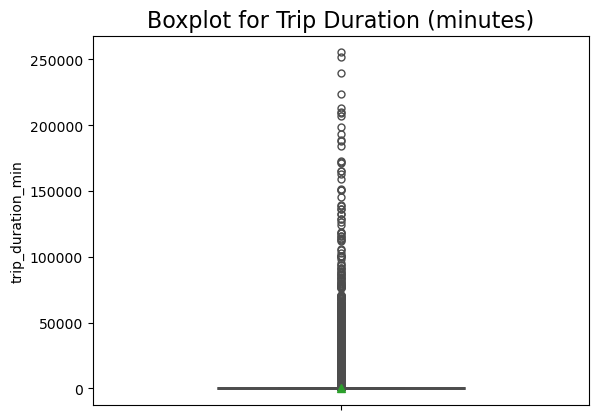

In [8]:

#~ visualizing the trip_duration_min distribution with a boxplot
sns.boxplot(
    data=bixi_trip_df,                
    y='trip_duration_min',     
    palette='bright',        
    width=0.5,              
    linewidth=2,            
    fliersize=5,           
    showmeans=True         
)

plt.title('Boxplot for Trip Duration (minutes)', fontsize=16)
plt.show()

it seems like there is many outliers. Looking further down in trip duration and BIXI's business model, 
they charge  18 cents after 45 minutes of the initial use. This encourage people to dock their bikes
for a break to restart the 45-minutes free period. With this in mind, we put a hard cutoff for any trip duration that is more than 120 min. 


In [9]:

bixi_trip_df = bixi_trip_df[bixi_trip_df["trip_duration_min"] <= 120]

It's time to start merging the datasets to get our final dataframe for our model

In [10]:

#~ floor BIXI trip starttime to the nearest hour to merge with weather data
bixi_trip_df['starttime_hourly'] = bixi_trip_df['starttime'].dt.floor('h')

In [11]:

#~ merging BIXI trip data with weather data

bixi_weather_df = bixi_trip_df.merge(
    weather_df,
    how="left",
    left_on="starttime_hourly",
    right_on="time"
)

In [12]:

#~ aggregating data to create the modeling dataframe with total demand per station per hour

model_df = (
    bixi_weather_df
    .groupby(["startstationname", "starttime_hourly"])
    .agg(
        total_demand=("trip_duration_min", "count"),
        arrondissement=("startstationarrondissement", "first"),
        temperature=("temperature", "mean"),
        precipitation=("precipitation", "mean"),
        wind_speed=("wind_speed", "mean"),
        latitude=("startstationlatitude", "first"),
        longitude=("startstationlongitude", "first")
        
    )
    .reset_index()
)


There were some missing temperature data at the end of the year so we just removed those. 

In [13]:

model_df.isna().sum()

startstationname       0
starttime_hourly       0
total_demand           0
arrondissement         0
temperature         1580
precipitation       1580
wind_speed          1580
latitude               0
longitude              0
dtype: int64

In [14]:

#~ removing rows with missing weather data 
model_df = model_df.dropna(subset=['temperature', 'precipitation', 'wind_speed']).reset_index(drop=True)

# Feature Engineering

In [ ]:

#~ sorting by station name and starttime_hourly
model_df = model_df.sort_values(by=['startstationname', 'starttime_hourly']).reset_index(drop=True)

#~ bringing out the hour 

model_df['hour'] = model_df['starttime_hourly'].dt.hour

#~ bringing out the day of week
model_df['day_of_week'] = model_df['starttime_hourly'].dt.dayofweek #~Monday=0, Sunday=6

#~ is weekend flag
model_df['is_weekend'] = model_df['day_of_week'].isin([5, 6]).astype(int)

#~month of year
model_df['month'] = model_df['starttime_hourly'].dt.month


#~ cyclical encoding for hour
model_df['hour_sin'] = np.sin(2 * np.pi * model_df['hour'] / 24)
model_df['hour_cos'] = np.cos(2 * np.pi * model_df['hour'] / 24)

#~ cyclical encoding for day of week
model_df['day_of_week_sin'] = np.sin(2 * np.pi * model_df['day_of_week'] / 7)
model_df['day_of_week_cos'] = np.cos(2 * np.pi * model_df['day_of_week'] / 7)

#~ weather feels like temperature
model_df["feels_like_temp"] = model_df["temperature"] - 0.7 * model_df["wind_speed"]

#~ rain indicator
model_df["is_raining"] = (model_df["precipitation"] > 0).astype(int)

#~  creating lags per station for total demand

    #~ 1h lag
model_df["lag_1h"] = model_df.groupby("startstationname")["total_demand"].shift(1)
    #~ 24h lag
model_df["lag_24h"] = model_df.groupby("startstationname")["total_demand"].shift(24)

#~ creating rolling means per station for total demand

model_df["rolling_3h"] = (
    model_df.groupby("startstationname")["total_demand"]
    .shift(1)
    .groupby(model_df["startstationname"])
    .rolling(3)
    .mean()
    .reset_index(level=0, drop=True)
)

model_df["rolling_24h"] = (
    model_df.groupby("startstationname")["total_demand"]
    .shift(1)
    .groupby(model_df["startstationname"])
    .rolling(24)
    .mean()
    .reset_index(level=0, drop=True)
)

#~ keeping station name as category
model_df["startstationname"] = model_df["startstationname"].astype("category")

#~ keeping arrondissement as category
model_df["arrondissement"] = model_df["arrondissement"].astype("category")   





In [16]:

#~ dropping rows with missing lags (this is the warm up period)

model_df = model_df.dropna().reset_index(drop=True)


In [17]:

#~ parquet the final model dataframe

model_df.to_parquet(PROCESSED_DIR/'model_df.parquet', index=False)